In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# !pip list | egrep '(matplotlib |numpy |torch |torchvision)'
!pip list | findstr "matplotlib numpy torch torchvision"

matplotlib                3.7.1
matplotlib-inline         0.1.6
numpy                     1.26.0
torch                     2.6.0+cu118
torchvision               0.21.0+cu118


In [25]:
import torch

seed = 2023

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(seed=seed)
torch.set_float32_matmul_precision("high")

if device.type == 'cuda':
    torch.cuda.manual_seed_all(seed=seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [26]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

train_dataset = datasets.MNIST(
    root='./mnist_data/',
    train=True,
    transform=transforms.ToTensor(),
    download=True)

test_dataset = datasets.MNIST(
    root='./mnist_data/',
    train=False,
    transform=transforms.ToTensor(),
    download=True
)

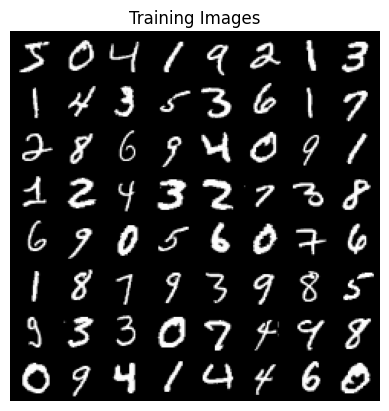

In [27]:
from torchvision import utils
import matplotlib
from matplotlib import pyplot as plt
import numpy as np

plt.axis('off')
plt.title("Training Images")
plt.imshow(np.transpose(utils.make_grid(torch.cat([train_dataset[i][0].unsqueeze(0) for i in range(64)], dim=0), normalize=True), (1,2,0)))

In [28]:
from torch import nn
import torch.nn.functional as F

class Encoder(nn.Module):
    def __init__(self, latent_dim: int=20):
        super().__init__()

        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc_mean = nn.Linear(128, latent_dim)

    def forward(self, x: torch.Tensor):
        x = x.view(x.size(0), -1)
        x = F.leaky_relu(self.fc1(x), negative_slope=0.2)
        x = F.leaky_relu(self.fc2(x), negative_slope=0.2)
        z = F.leaky_relu(self.fc_mean(x))
        return z
    
class Decoder(nn.Module):
    def __init__(self, latent_dim: int=20):
        super().__init__()

        self.fc1 = nn.Linear(latent_dim, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 784)

    def forward(self, z: torch.Tensor):
        z = F.leaky_relu(self.fc1(z), negative_slope=0.2)
        z = F.leaky_relu(self.fc2(z), negative_slope=0.2)
        x_hat = F.sigmoid(self.fc3(z))
        x_hat = x_hat.view(x_hat.size(0), 1, 28, 28)

        return x_hat

In [29]:
class Autoencoder(nn.Module):
    def __init__(self, encoder=Encoder, decoder=Decoder, latent_dim: int=20):
        super().__init__()

        self.encoder = encoder(latent_dim=latent_dim)
        self.decoder = decoder(latent_dim=latent_dim)

        self.latent_dim = latent_dim

    def forward(self, x: torch.Tensor):
        z = self.encode(x)
        x_hat = self.decode(z)
        return z, x_hat

    def encode(self, x: torch.Tensor):
        return self.encoder(x)

    def decode(self, z: torch.Tensor):
        return self.decoder(z)

In [30]:
learning_rate = 0.001
batch_size = 100
epochs = 10
latent_dim = 20

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False)

In [31]:
from torch import optim

autoencoder = Autoencoder(latent_dim=latent_dim).to(device)

recon_loss = nn.MSELoss(reduction='sum')

optimizer = optim.Adam(params=list(autoencoder.parameters()), lr=learning_rate)

In [32]:
history = dict(
    train_loss=[],
    valid_loss=[]
)

print(f"Training start with {epochs} epochs.")
for epoch in range(1, 1 + epochs):
    train_epoch_loss = 0
    train_size = 0

    autoencoder.train()
    for i, batch in enumerate(train_loader):
        image, label = batch
        image = image.to(device)

        train_size += label.size(0)
        
        latent = autoencoder.encode(image)
        reconstruction_image = autoencoder.decode(latent)

        optimizer.zero_grad()

        train_loss = recon_loss(image, reconstruction_image)
        train_loss.backward()
        optimizer.step()
        train_epoch_loss += train_loss

    test_epoch_loss = 0
    test_size = 0

    autoencoder.eval()
    with torch.no_grad():
        for i, batch in enumerate(test_loader):
            image, label = batch
            image = image.to(device)
            test_size += label.size(0)

            latent = autoencoder.encode(image)
            reconstruction_image = autoencoder.decode(latent)

            test_loss = recon_loss(image, reconstruction_image)
            test_epoch_loss += test_loss

    train_epoch_loss /= train_size
    test_epoch_loss /= test_size

    history["train_loss"].append(train_epoch_loss.item())
    history["valid_loss"].append(test_epoch_loss.item())

    print(
        f"[{epoch:02d}/{epochs:02d}]"
        + f"Train MSE Loss = {train_epoch_loss:.4f}, "
        + f"Valid MSE Loss = {test_epoch_loss:.4f}"
    )




Training start with 10 epochs.
[01/10]Train MSE Loss = 36.8864, Valid MSE Loss = 20.6704
[02/10]Train MSE Loss = 17.5687, Valid MSE Loss = 15.2714
[03/10]Train MSE Loss = 14.3679, Valid MSE Loss = 13.0135
[04/10]Train MSE Loss = 12.6859, Valid MSE Loss = 11.7377
[05/10]Train MSE Loss = 11.2271, Valid MSE Loss = 10.5295
[06/10]Train MSE Loss = 10.3201, Valid MSE Loss = 9.7404
[07/10]Train MSE Loss = 9.6059, Valid MSE Loss = 9.2877
[08/10]Train MSE Loss = 9.0592, Valid MSE Loss = 8.7273
[09/10]Train MSE Loss = 8.5882, Valid MSE Loss = 8.3390
[10/10]Train MSE Loss = 8.2171, Valid MSE Loss = 7.9488


In [33]:
def visualize_loss(epochs, train_loss, valid_loss):
    x_len = np.arange(epochs)

    plt.plot(x_len, train_loss, marker=".", c="blue", label="Train Loss")
    plt.plot(x_len, valid_loss, marker=".", c="red", label="Valid Loss")
    
    plt.legend(loc='upper right')
    plt.grid()
    
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

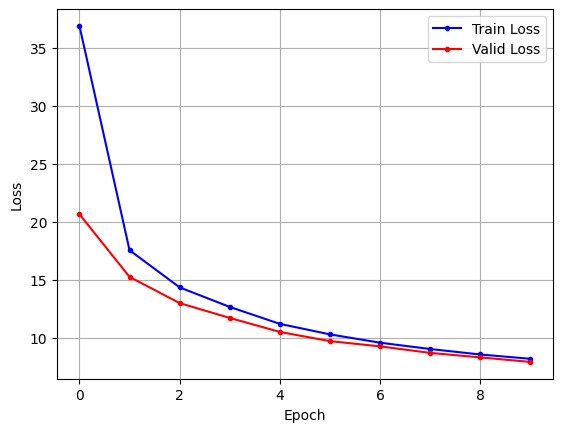

In [34]:
visualize_loss(epochs, history["train_loss"], history["valid_loss"])

In [35]:
select = 0

autoencoder.eval()
with torch.no_grad():
    for i, batch in enumerate(test_loader):
        if i != select:
            continue
        else:
            test_image, test_label = batch

            test_image = test_image.to(device)
            test_image = test_image.view(batch_size, 1 * 28 * 28)

            z = autoencoder.encode(test_image)
            reconstruction = autoencoder.decode(z)
            break

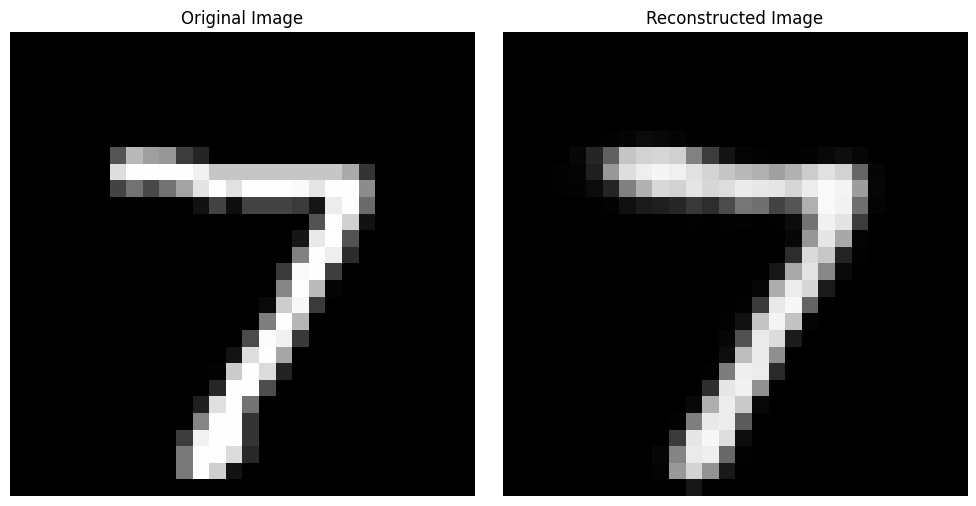

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# 원본 이미지
axes[0].imshow(utils.make_grid(test_image[0].cpu().view(-1, 1, 28, 28)).permute(1, 2, 0))
axes[0].set_title('Original Image')
axes[0].axis('off') # 축 제거

# 복원된 이미지
axes[1].imshow(utils.make_grid(reconstruction[0].cpu().view(-1, 1, 28, 28)).permute(1, 2, 0))
axes[1].set_title('Reconstructed Image')
axes[1].axis('off') # 축 제거

plt.tight_layout()
plt.show()

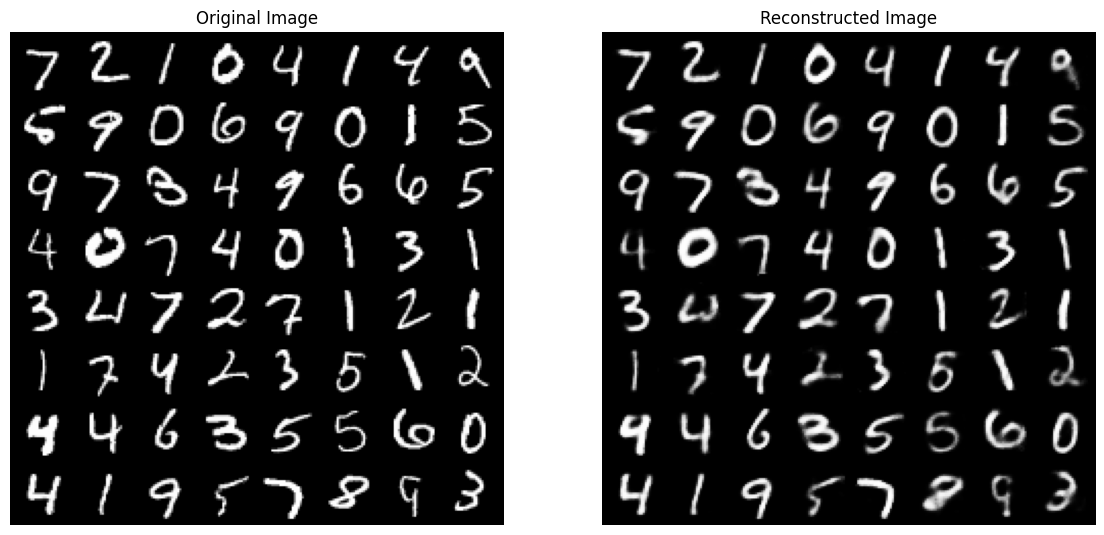

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

axes[0].imshow(utils.make_grid(test_image[:64].cpu().view(-1, 1, 28, 28)).permute(1, 2, 0))
axes[0].set_title("Original Image")
axes[0].axis('off')

axes[1].imshow(utils.make_grid(reconstruction[:64].cpu().view(-1, 1, 28, 28)).permute(1, 2, 0))
axes[1].set_title("Reconstructed Image")
axes[1].axis('off')

plt.show()

In [38]:
from sklearn.manifold import TSNE

test_latents = []
test_labels = []

with torch.no_grad():
    for i, batch in enumerate(test_loader):
        test_image, test_label = batch

        test_image = test_image.to(device)
        test_image = test_image.view(batch_size, 784)

        z = autoencoder.encode(test_image)
        test_latents.append(z)
        test_labels.append(test_label)

test_latents = torch.cat(test_latents).cpu().numpy()
test_labels = torch.cat(test_labels).cpu().numpy()

tsne = TSNE(n_components=2).fit_transform(test_latents)

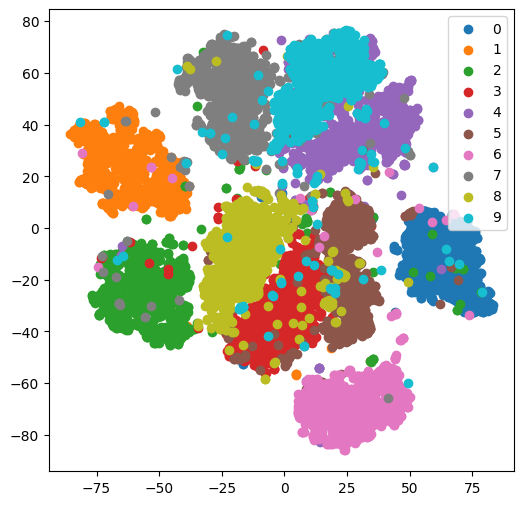

In [39]:
plt.figure(figsize=(6, 6))

target_ids = range(10)
colors = (
    'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple',
    'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'
)

for i, c, label in zip(target_ids, colors, range(10)):
    plt.scatter(tsne[test_labels == i, 0], tsne[test_labels == i, 1], c=c, label=label)
plt.legend()
plt.show()

In [41]:
test_images = []
test_labels = []

with torch.no_grad():
    for i, batch in enumerate(test_loader):
        test_image, test_label = batch
        test_image = test_image.view(batch_size, 784)

        test_images.append(test_image)
        test_labels.append(test_label)

test_images = torch.cat(test_images).cpu().numpy()
test_labels = torch.cat(test_labels).cpu().numpy()

tsne = TSNE(n_components=2).fit_transform(test_images)

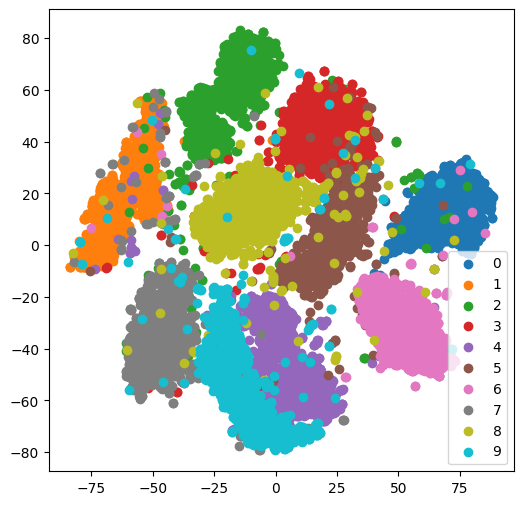

In [42]:
target_ids = range(10)

plt.figure(figsize=(6, 6))
colors = (
    'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple',
    'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'
)

for i, c, label in zip(target_ids, colors, range(10)):
    plt.scatter(tsne[test_labels == i, 0], tsne[test_labels == i, 1], c=c, label=label)
plt.legend()
plt.show()